In [ ]:
import pandas as pd
df= pd.read_csv('/content/drive/MyDrive/final_project/review_data.csv')


In [ ]:
df

,category,rating,label,text_
0,Home_and_Kitchen_5,5.0,CG,love well made sturdy comfortable love itvery ...
1,Home_and_Kitchen_5,5.0,CG,love great upgrade original ive mine couple year
2,Home_and_Kitchen_5,5.0,CG,pillow saved back love look feel pillow
3,Home_and_Kitchen_5,1.0,CG,missing information use great product price
4,Home_and_Kitchen_5,5.0,CG,nice set good quality set two month
...,...,...,...,...
40427,Clothing_Shoes_and_Jewelry_5,4.0,OR,read review saying bra ran small ordered two b...
40428,Clothing_Shoes_and_Jewelry_5,5.0,CG,wasnt sure exactly would little large small si...
40429,Clothing_Shoes_and_Jewelry_5,2.0,OR,wear hood wear hood wear jacket without hood s...
40430,Clothing_Shoes_and_Jewelry_5,1.0,CG,liked nothing dress reason gave star ordered s...


In [ ]:
df.isnull().sum()

,0
category,0
rating,0
label,0
text_,1


In [ ]:
df.dropna(inplace=True) #since only one

# Best fitting model for clustering

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import pandas as pd

# Update CountVectorizer parameters
count_vectorizer = CountVectorizer(stop_words='english', max_features=None, ngram_range=(1, 2))
X_count = count_vectorizer.fit_transform(df['text_'])  # Sparse matrix (do not convert to dense)

# Update TruncatedSVD parameters
svd = TruncatedSVD(n_components=10, random_state=42)  # Reduce to 10 dimensions
X_svd = svd.fit_transform(X_count)

# Update K-Means parameters
kmeans_count = KMeans(n_clusters=5, random_state=42)
kmeans_count.fit(X_svd)

# Predict clusters
clusters_count = kmeans_count.labels_

# Display results
df_result = pd.DataFrame({'Review': df['text_'], 'Cluster': clusters_count})
print("Clustering with Updated Parameters:")
print(df_result)

# Calculate Silhouette Score
silhouette_avg = silhouette_score(X_svd, clusters_count)
print(f"Silhouette Score (Updated Parameters): {silhouette_avg:.4f}")


Clustering with Updated Parameters:
                                                  Review  Cluster
0      love well made sturdy comfortable love itvery ...        1
1       love great upgrade original ive mine couple year        1
2                pillow saved back love look feel pillow        1
3            missing information use great product price        1
4                    nice set good quality set two month        1
...                                                  ...      ...
40427  read review saying bra ran small ordered two b...        1
40428  wasnt sure exactly would little large small si...        1
40429  wear hood wear hood wear jacket without hood s...        1
40430  liked nothing dress reason gave star ordered s...        1
40431  work wedding industry work long day foot outsi...        1

[40431 rows x 2 columns]
Silhouette Score (Updated Parameters): 0.7059


# pipeline and pickling

In [ ]:
from sklearn.pipeline import Pipeline
import pandas as pd
import pickle


# Define the pipeline
pipeline = Pipeline([
    ('vectorizer', CountVectorizer(stop_words='english', max_features=None, ngram_range=(1, 2))),
    ('svd', TruncatedSVD(n_components=10, random_state=42)),
    ('kmeans', KMeans(n_clusters=5, random_state=42))
])

# Fit the pipeline on the text data
pipeline.fit(df['text_'])

# Save the pipeline to a file
with open('/content/drive/MyDrive/final_project/clustering_pipeline.pkl', 'wb') as f:
    pickle.dump(pipeline, f)

print("Pipeline has been saved to 'clustering_pipeline.pkl'.")

Pipeline has been saved to 'clustering_pipeline.pkl'.


## testing

In [ ]:
with open('/content/drive/MyDrive/final_project/clustering_pipeline.pkl', 'rb') as f:
    loaded_pipeline = pickle.load(f)

pred=loaded_pipeline.predict([df['text_'].iloc[10]])
print(pred)

[1]


In [27]:
pip freeze > requirements.txt

# the above model is predicted by

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import ParameterGrid
import pandas as pd

# Define parameter grid
param_grid = {
    'vectorizer__max_features': [5000, 10000, None],
    'vectorizer__ngram_range': [(1, 1), (1, 2)],
    'svd__n_components': [2, 5, 10],
    'kmeans__n_clusters': [5, 7, 10]
}

# Initialize vectorizer and dimensionality reduction
vectorizer = CountVectorizer(stop_words='english')
svd = TruncatedSVD(random_state=42)

results = []

# Manual grid search
for params in ParameterGrid(param_grid):
    # Set CountVectorizer parameters
    vectorizer.set_params(
        max_features=params['vectorizer__max_features'],
        ngram_range=params['vectorizer__ngram_range']
    )
    # Transform text data
    X_count = vectorizer.fit_transform(df['text_'])

    # Set TruncatedSVD parameters
    svd.set_params(n_components=params['svd__n_components'])
    X_svd = svd.fit_transform(X_count)

    # Set KMeans parameters and fit
    kmeans = KMeans(n_clusters=params['kmeans__n_clusters'], random_state=42)
    kmeans.fit(X_svd)
    clusters = kmeans.labels_

    # Calculate silhouette score
    silhouette_avg = silhouette_score(X_svd, clusters)
    results.append((params, silhouette_avg))

# Sort results by silhouette score
results = sorted(results, key=lambda x: x[1], reverse=True)

# Display best results
best_params, best_score = results[0]
print("Best Silhouette Score:", best_score)
print("Best Parameters:", best_params)


Best Silhouette Score: 0.7058690046826401
Best Parameters: {'kmeans__n_clusters': 5, 'svd__n_components': 10, 'vectorizer__max_features': None, 'vectorizer__ngram_range': (1, 2)}


# Other tested models

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# 1. Preprocess and Vectorize Text (TF-IDF Vectorizer)
tfidf = TfidfVectorizer(stop_words='english', max_features=5000)  # You can adjust max_features
X = tfidf.fit_transform(df["text_"])

# 2. Apply KMeans Clustering
n_clusters = 5  # Assuming you want to find 2 clusters (fake vs real)
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(X)

# 3. Assign Cluster Labels to Documents
df['Cluster'] = kmeans.labels_

# 4. Analyze Topics (Top terms per cluster)
terms = tfidf.get_feature_names_out()
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]

print("Top terms per cluster:")
for i in range(n_clusters):
    print(f"Cluster {i}:")
    print(", ".join([terms[ind] for ind in order_centroids[i, :10]]))  # Top 5 terms per cluster




Top terms per cluster:
Cluster 0:
movie, good, acting, watch, story, great, love, film, action, like
Cluster 1:
book, read, story, character, series, author, enjoyed, good, reading, developed
Cluster 2:
fit, size, comfortable, shoe, wear, perfect, ordered, little, nice, love
Cluster 3:
great, work, good, like, use, little, nice, quality, product, easy
Cluster 4:
love, dog, toy, son, bought, great, cat, daughter, year, play


# using CountVectorizer

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
import pandas as pd

# Vectorize the reviews using CountVectorizer
count_vectorizer = CountVectorizer(stop_words='english')
X_count = count_vectorizer.fit_transform(df['text_'])

# Apply K-Means Clustering
kmeans_count = KMeans(n_clusters=4, random_state=42)
kmeans_count.fit(X_count)

# Predict clusters
clusters_count = kmeans_count.labels_

# Display results
df_count = pd.DataFrame({'Review': df['text_'], 'Cluster': clusters_count})
print("Clustering with CountVectorizer:")
print(df_count)

from sklearn.metrics import silhouette_score

# Silhouette Scores
sil_count = silhouette_score(X_count, clusters_count)
print(f"Silhouette Score (CountVectorizer): {sil_count}")


Clustering with CountVectorizer:
                                                  Review  Cluster
0      love well made sturdy comfortable love itvery ...        1
1       love great upgrade original ive mine couple year        1
2                pillow saved back love look feel pillow        1
3            missing information use great product price        1
4                    nice set good quality set two month        1
...                                                  ...      ...
40427  read review saying bra ran small ordered two b...        2
40428  wasnt sure exactly would little large small si...        2
40429  wear hood wear hood wear jacket without hood s...        2
40430  liked nothing dress reason gave star ordered s...        2
40431  work wedding industry work long day foot outsi...        2

[40431 rows x 2 columns]
Silhouette Score (CountVectorizer): 0.3647100470007249


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import pandas as pd


# Vectorize the reviews using CountVectorizer
count_vectorizer = CountVectorizer(stop_words='english')
X_count = count_vectorizer.fit_transform(df['text_']).toarray()  # Convert sparse matrix to dense

# Apply PCA for dimensionality reduction
pca = PCA(n_components=5000)  # Reduce to 2 components for visualization
X_pca = pca.fit_transform(X_count)

# Apply K-Means Clustering
kmeans_count_pca = KMeans(n_clusters=4, random_state=42)
kmeans_count_pca.fit(X_pca)

# Predict clusters
clusters_count_pca = kmeans_count_pca.labels_

# Display results
df_count_pca = pd.DataFrame({'Review': df['text_'], 'Cluster': clusters_count_pca})
print("Clustering with CountVectorizer + PCA:")
print(df_count_pca)

# Silhouette Score
sil_count_pca = silhouette_score(X_pca, clusters_count_pca)
print(f"Silhouette Score (CountVectorizer + PCA): {sil_count_pca:.4f}")


pca is not working

# using TruncatedSVD in kmeans with countvectorizer

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import pandas as pd


# Vectorize the text data using CountVectorizer
count_vectorizer = CountVectorizer(stop_words='english')
X_count = count_vectorizer.fit_transform(df['text_'])  # Sparse matrix (do not convert to dense)

# Apply TruncatedSVD for dimensionality reduction
svd = TruncatedSVD(n_components=2, random_state=42)  # Reduce to 2 dimensions
X_svd = svd.fit_transform(X_count)

# Apply K-Means clustering
kmeans_count = KMeans(n_clusters=7, random_state=42)
kmeans_count.fit(X_svd)

# Predict clusters
clusters_count = kmeans_count.labels_

# Display results
df_result = pd.DataFrame({'Review': df['text_'], 'Cluster': clusters_count})
print("Clustering with CountVectorizer + TruncatedSVD:")
print(df_result)

# Calculate Silhouette Score
silhouette_avg = silhouette_score(X_svd, clusters_count)
print(f"Silhouette Score (CountVectorizer + TruncatedSVD): {silhouette_avg:.4f}")


Clustering with CountVectorizer + TruncatedSVD:
                                                  Review  Cluster
0      love well made sturdy comfortable love itvery ...        1
1       love great upgrade original ive mine couple year        1
2                pillow saved back love look feel pillow        1
3            missing information use great product price        1
4                    nice set good quality set two month        1
...                                                  ...      ...
40427  read review saying bra ran small ordered two b...        2
40428  wasnt sure exactly would little large small si...        0
40429  wear hood wear hood wear jacket without hood s...        2
40430  liked nothing dress reason gave star ordered s...        0
40431  work wedding industry work long day foot outsi...        0

[40431 rows x 2 columns]
Silhouette Score (CountVectorizer + TruncatedSVD): 0.5698


Number of Clusters: 2, Silhouette Score: 0.7787
Number of Clusters: 3, Silhouette Score: 0.6466
Number of Clusters: 4, Silhouette Score: 0.5084
Number of Clusters: 5, Silhouette Score: 0.5679
Number of Clusters: 6, Silhouette Score: 0.5526
Number of Clusters: 7, Silhouette Score: 0.5698
Number of Clusters: 8, Silhouette Score: 0.5151
Number of Clusters: 9, Silhouette Score: 0.4937


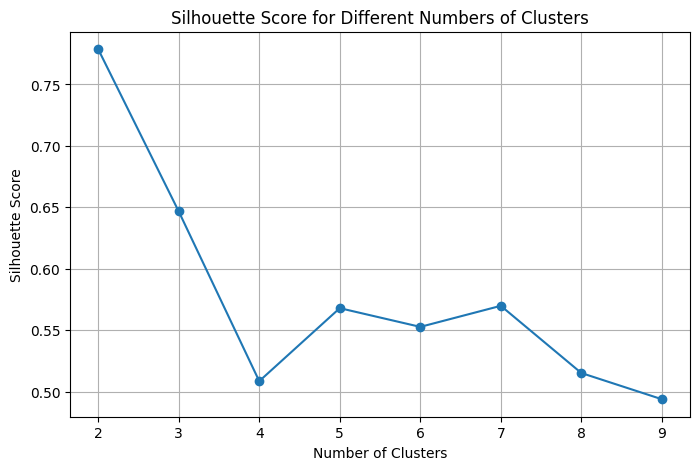

Optimal Number of Clusters: 2
Clustering with Optimal K-Means + TruncatedSVD:
                                                  Review  Cluster
0      love well made sturdy comfortable love itvery ...        1
1       love great upgrade original ive mine couple year        1
2                pillow saved back love look feel pillow        1
3            missing information use great product price        1
4                    nice set good quality set two month        1
...                                                  ...      ...
40427  read review saying bra ran small ordered two b...        1
40428  wasnt sure exactly would little large small si...        1
40429  wear hood wear hood wear jacket without hood s...        1
40430  liked nothing dress reason gave star ordered s...        1
40431  work wedding industry work long day foot outsi...        1

[40431 rows x 2 columns]
Final Silhouette Score: 0.7787


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import pandas as pd
import matplotlib.pyplot as plt

# Vectorize the text data using CountVectorizer
count_vectorizer = CountVectorizer(stop_words='english')
X_count = count_vectorizer.fit_transform(df['text_'])  # Sparse matrix (do not convert to dense)

# Apply TruncatedSVD for dimensionality reduction
svd = TruncatedSVD(n_components=2, random_state=42)  # Reduce to 2 dimensions
X_svd = svd.fit_transform(X_count)

# Hyperparameter tuning: Find the best number of clusters
silhouette_scores = []
range_n_clusters = range(2, 10)  # Try between 2 and 10 clusters

for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(X_svd)

    # Calculate silhouette score for the current number of clusters
    sil_score = silhouette_score(X_svd, cluster_labels)
    silhouette_scores.append(sil_score)
    print(f"Number of Clusters: {n_clusters}, Silhouette Score: {sil_score:.4f}")

# Plot silhouette scores to visualize the best cluster number
plt.figure(figsize=(8, 5))
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.title("Silhouette Score for Different Numbers of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

# Select the best number of clusters based on silhouette score
optimal_n_clusters = range_n_clusters[silhouette_scores.index(max(silhouette_scores))]
print(f"Optimal Number of Clusters: {optimal_n_clusters}")

# Apply K-Means with the optimal number of clusters
kmeans_optimal = KMeans(n_clusters=optimal_n_clusters, random_state=42)
clusters_optimal = kmeans_optimal.fit_predict(X_svd)

# Display final results
df_result = pd.DataFrame({'Review': df['text_'], 'Cluster': clusters_optimal})
print("Clustering with Optimal K-Means + TruncatedSVD:")
print(df_result)

# Final Silhouette Score
final_silhouette_score = silhouette_score(X_svd, clusters_optimal)
print(f"Final Silhouette Score: {final_silhouette_score:.4f}")


# with TfidfVectorizer

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Vectorize the reviews using TF-IDF
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
X_tfidf = tfidf_vectorizer.fit_transform(df['text_'])

# Apply K-Means Clustering
kmeans_tfidf = KMeans(n_clusters=4, random_state=42)
kmeans_tfidf.fit(X_tfidf)

# Predict clusters
clusters_tfidf = kmeans_tfidf.labels_

# Display results
df_tfidf = pd.DataFrame({'Review': df['text_'], 'Cluster': clusters_tfidf})
print("Clustering with TF-IDF Vectorizer:")
print(df_tfidf)

from sklearn.metrics import silhouette_score

# Silhouette Scores
sil_tfidf = silhouette_score(X_tfidf, clusters_tfidf)
print(f"Silhouette Score (TF-IDF): {sil_tfidf}")

Clustering with TF-IDF Vectorizer:
                                                  Review  Cluster
0      love well made sturdy comfortable love itvery ...        3
1       love great upgrade original ive mine couple year        3
2                pillow saved back love look feel pillow        2
3            missing information use great product price        2
4                    nice set good quality set two month        2
...                                                  ...      ...
40427  read review saying bra ran small ordered two b...        2
40428  wasnt sure exactly would little large small si...        3
40429  wear hood wear hood wear jacket without hood s...        2
40430  liked nothing dress reason gave star ordered s...        3
40431  work wedding industry work long day foot outsi...        3

[40431 rows x 2 columns]
Silhouette Score (TF-IDF): 0.00859828809570015


# tfidf-svd-review

Number of Clusters: 2, Silhouette Score: 0.6761
Number of Clusters: 3, Silhouette Score: 0.4705
Number of Clusters: 4, Silhouette Score: 0.5091
Number of Clusters: 5, Silhouette Score: 0.4963
Number of Clusters: 6, Silhouette Score: 0.4948
Number of Clusters: 7, Silhouette Score: 0.4493
Number of Clusters: 8, Silhouette Score: 0.4483
Number of Clusters: 9, Silhouette Score: 0.4338


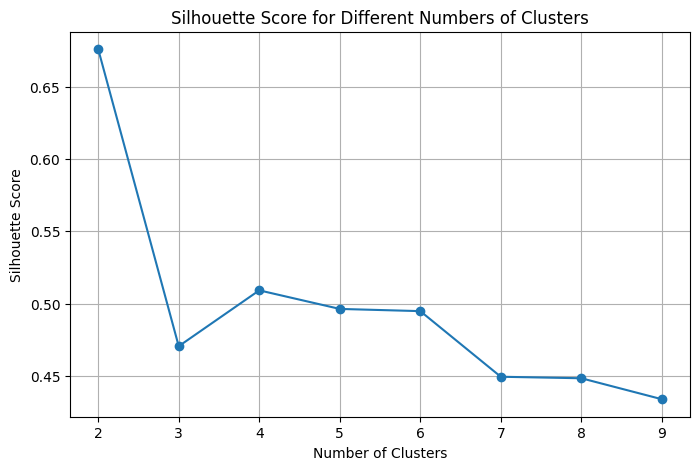

Optimal Number of Clusters: 2
Clustering with Optimal K-Means + TruncatedSVD + TF-IDF:
                                                  Review  Cluster
0      love well made sturdy comfortable love itvery ...        1
1       love great upgrade original ive mine couple year        1
2                pillow saved back love look feel pillow        1
3            missing information use great product price        1
4                    nice set good quality set two month        1
...                                                  ...      ...
40427  read review saying bra ran small ordered two b...        1
40428  wasnt sure exactly would little large small si...        1
40429  wear hood wear hood wear jacket without hood s...        1
40430  liked nothing dress reason gave star ordered s...        1
40431  work wedding industry work long day foot outsi...        1

[40431 rows x 2 columns]
Final Silhouette Score: 0.6761


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import pandas as pd
import matplotlib.pyplot as plt

# Vectorize the text data using TfidfVectorizer (instead of CountVectorizer)
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
X_tfidf = tfidf_vectorizer.fit_transform(df['text_'])  # Sparse matrix (do not convert to dense)

# Apply TruncatedSVD for dimensionality reduction
svd = TruncatedSVD(n_components=2, random_state=42)  # Reduce to 2 dimensions
X_svd = svd.fit_transform(X_tfidf)

# Hyperparameter tuning: Find the best number of clusters
silhouette_scores = []
range_n_clusters = range(2, 10)  # Try between 2 and 10 clusters

for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(X_svd)

    # Calculate silhouette score for the current number of clusters
    sil_score = silhouette_score(X_svd, cluster_labels)
    silhouette_scores.append(sil_score)
    print(f"Number of Clusters: {n_clusters}, Silhouette Score: {sil_score:.4f}")

# Plot silhouette scores to visualize the best cluster number
plt.figure(figsize=(8, 5))
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.title("Silhouette Score for Different Numbers of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

# Select the best number of clusters based on silhouette score
optimal_n_clusters = range_n_clusters[silhouette_scores.index(max(silhouette_scores))]
print(f"Optimal Number of Clusters: {optimal_n_clusters}")

# Apply K-Means with the optimal number of clusters
kmeans_optimal = KMeans(n_clusters=optimal_n_clusters, random_state=42)
clusters_optimal = kmeans_optimal.fit_predict(X_svd)

# Display final results
df_result = pd.DataFrame({'Review': df['text_'], 'Cluster': clusters_optimal})
print("Clustering with Optimal K-Means + TruncatedSVD + TF-IDF:")
print(df_result)

# Final Silhouette Score
final_silhouette_score = silhouette_score(X_svd, clusters_optimal)
print(f"Final Silhouette Score: {final_silhouette_score:.4f}")


# using Word2Vector

In [ ]:
from gensim.models import Word2Vec
import numpy as np

# Tokenize reviews into words
tokenized_reviews = [review.lower().split() for review in df['text_']]

# Train a Word2Vec model (or use a pre-trained model like Google Word2Vec)
word2vec_model = Word2Vec(sentences=tokenized_reviews, vector_size=100, window=5, min_count=1, workers=4)

# Create document vectors by averaging word vectors
def document_vector(doc):
    words = [word for word in doc if word in word2vec_model.wv]
    return np.mean([word2vec_model.wv[word] for word in words], axis=0)

doc_vectors = np.array([document_vector(doc) for doc in tokenized_reviews])

# Apply K-Means Clustering
kmeans_word2vec = KMeans(n_clusters=4, random_state=42)
kmeans_word2vec.fit(doc_vectors)

# Predict clusters
clusters_word2vec = kmeans_word2vec.labels_

# Display results
df_word2vec = pd.DataFrame({'Review': df['text_'], 'Cluster': clusters_word2vec})
print("Clustering with Word2Vec:")
print(df_word2vec)

from sklearn.metrics import silhouette_score

# Silhouette Scores
sil_word2vec = silhouette_score(doc_vectors, clusters_word2vec)
print(f"Silhouette Score (Word2Vec): {sil_word2vec}")


Clustering with Word2Vec:
                                                  Review  Cluster
0      love well made sturdy comfortable love itvery ...        1
1       love great upgrade original ive mine couple year        1
2                pillow saved back love look feel pillow        3
3            missing information use great product price        1
4                    nice set good quality set two month        1
...                                                  ...      ...
40427  read review saying bra ran small ordered two b...        2
40428  wasnt sure exactly would little large small si...        3
40429  wear hood wear hood wear jacket without hood s...        2
40430  liked nothing dress reason gave star ordered s...        3
40431  work wedding industry work long day foot outsi...        2

[40431 rows x 2 columns]
Silhouette Score (Word2Vec): 0.1506938636302948


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Number of Clusters: 2, Silhouette Score: 0.5067
Number of Clusters: 3, Silhouette Score: 0.4425
Number of Clusters: 4, Silhouette Score: 0.4082
Number of Clusters: 5, Silhouette Score: 0.3773
Number of Clusters: 6, Silhouette Score: 0.3576
Number of Clusters: 7, Silhouette Score: 0.3362
Number of Clusters: 8, Silhouette Score: 0.3376
Number of Clusters: 9, Silhouette Score: 0.3353


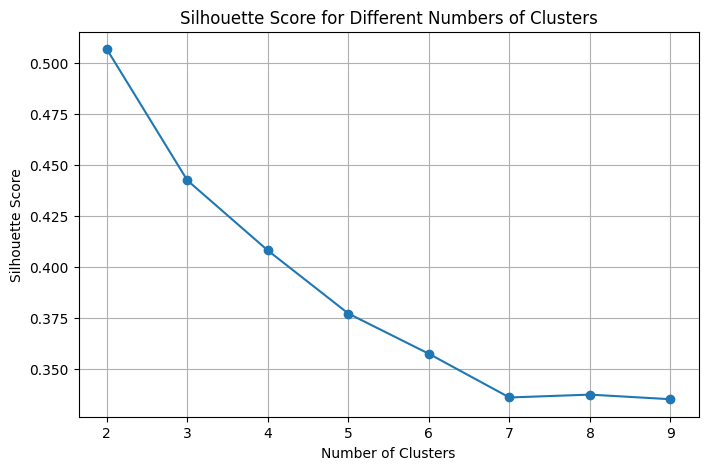

Optimal Number of Clusters: 2
Clustering with Optimal K-Means + Word2Vec + TruncatedSVD:
                                                  Review  Cluster
0      love well made sturdy comfortable love itvery ...        1
1       love great upgrade original ive mine couple year        1
2                pillow saved back love look feel pillow        1
3            missing information use great product price        1
4                    nice set good quality set two month        1
...                                                  ...      ...
40427  read review saying bra ran small ordered two b...        1
40428  wasnt sure exactly would little large small si...        1
40429  wear hood wear hood wear jacket without hood s...        1
40430  liked nothing dress reason gave star ordered s...        1
40431  work wedding industry work long day foot outsi...        1

[40431 rows x 2 columns]
Final Silhouette Score: 0.5067


In [ ]:
import gensim
from gensim.models import Word2Vec
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')

# Preprocess text: Tokenization
def preprocess_text(text):
    return word_tokenize(text.lower())  # Convert text to lowercase and tokenize

# Tokenize the text data
df['tokens'] = df['text_'].apply(preprocess_text)

# Train a Word2Vec model on the tokenized data
model_w2v = Word2Vec(sentences=df['tokens'], vector_size=100, window=5, min_count=1, workers=4)

# Convert each document to a vector by averaging the word vectors
def document_to_vector(tokens, model):
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    if vectors:
        return sum(vectors) / len(vectors)
    else:
        return [0] * model.vector_size  # Return a zero vector if no words are in the vocabulary

# Apply the document_to_vector function to get document vectors
X_w2v = df['tokens'].apply(lambda tokens: document_to_vector(tokens, model_w2v)).tolist()

# Convert to a DataFrame
X_w2v = pd.DataFrame(X_w2v)

# Apply TruncatedSVD for dimensionality reduction
svd = TruncatedSVD(n_components=2, random_state=42)  # Reduce to 2 dimensions
X_svd = svd.fit_transform(X_w2v)

# Hyperparameter tuning: Find the best number of clusters
silhouette_scores = []
range_n_clusters = range(2, 10)  # Try between 2 and 10 clusters

for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(X_svd)

    # Calculate silhouette score for the current number of clusters
    sil_score = silhouette_score(X_svd, cluster_labels)
    silhouette_scores.append(sil_score)
    print(f"Number of Clusters: {n_clusters}, Silhouette Score: {sil_score:.4f}")

# Plot silhouette scores to visualize the best cluster number
plt.figure(figsize=(8, 5))
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.title("Silhouette Score for Different Numbers of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

# Select the best number of clusters based on silhouette score
optimal_n_clusters = range_n_clusters[silhouette_scores.index(max(silhouette_scores))]
print(f"Optimal Number of Clusters: {optimal_n_clusters}")

# Apply K-Means with the optimal number of clusters
kmeans_optimal = KMeans(n_clusters=optimal_n_clusters, random_state=42)
clusters_optimal = kmeans_optimal.fit_predict(X_svd)

# Display final results
df_result = pd.DataFrame({'Review': df['text_'], 'Cluster': clusters_optimal})
print("Clustering with Optimal K-Means + Word2Vec + TruncatedSVD:")
print(df_result)

# Final Silhouette Score
final_silhouette_score = silhouette_score(X_svd, clusters_optimal)
print(f"Final Silhouette Score: {final_silhouette_score:.4f}")


In [ ]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
from sklearn.metrics import silhouette_score

# Silhouette Scores
sil_count = silhouette_score(X_count, clusters_count)
sil_tfidf = silhouette_score(X_tfidf, clusters_tfidf)
sil_word2vec = silhouette_score(doc_vectors, clusters_word2vec)

print(f"Silhouette Score (CountVectorizer): {sil_count}")
print(f"Silhouette Score (TF-IDF): {sil_tfidf}")
print(f"Silhouette Score (Word2Vec): {sil_word2vec}")


Silhouette Score (CountVectorizer): 0.3570656953818001
Silhouette Score (TF-IDF): 0.00903058881689248
Silhouette Score (Word2Vec): 0.10265577584505081


# DBSCAN - not working

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score


# Count Vectorizer
vectorizer = CountVectorizer()
count_matrix = vectorizer.fit_transform(df['text_']).toarray()

# DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=2, metric='cosine')
labels = dbscan.fit_predict(count_matrix)

# Silhouette Score
if len(set(labels)) > 1:
    silhouette_avg = silhouette_score(count_matrix, labels, metric='cosine')
    print(f"Silhouette Score for Count Vectorizer: {silhouette_avg:.4f}")
else:
    print("Silhouette Score for Count Vectorizer: Not applicable (single cluster)")


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

# TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(df['text_']).toarray()

# DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=2, metric='cosine')
labels = dbscan.fit_predict(tfidf_matrix)

# Silhouette Score
if len(set(labels)) > 1:
    silhouette_avg = silhouette_score(tfidf_matrix, labels, metric='cosine')
    print(f"Silhouette Score for TF-IDF: {silhouette_avg:.4f}")
else:
    print("Silhouette Score for TF-IDF: Not applicable (single cluster)")


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

# Count Vectorizer
vectorizer = CountVectorizer()
count_matrix = vectorizer.fit_transform(df['text_']).toarray()

# PCA for dimensionality reduction
pca = PCA(n_components=2)  # Reduce to 2 dimensions for visualization
count_pca = pca.fit_transform(count_matrix)

# DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=2, metric='euclidean')
labels = dbscan.fit_predict(count_pca)

# Silhouette Score
if len(set(labels)) > 1:
    silhouette_avg = silhouette_score(count_pca, labels)
    print(f"Silhouette Score for Count Vectorizer with PCA: {silhouette_avg:.4f}")
else:
    print("Silhouette Score for Count Vectorizer with PCA: Not applicable (single cluster)")
